<a href="https://colab.research.google.com/github/cerezamo/NLP_brouillon/blob/master/Camembert_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT classification model 

In [249]:
import spacy 
import numpy as np 
import pandas as pd 
import os 
os.getcwd()
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Set up Colab GPU 

In [250]:
# First you should go in 'Edit' -> 'Notebook settings' -> Add device GPU
import tensorflow as tf

# GPU device name.
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

Let's now tell torch that one GPU is available 

In [251]:
import torch

if torch.cuda.is_available():  
        
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Let's install the Hugging Face Library transformer package 

In [252]:
! pip install transformers 

### Loading our corpus and preprocessing 

In [0]:
import pandas as pd
# Import medium_df_desq in "files"
# Load the dataset into a pandas dataframe.
df=pd.read_csv('medium_df_deseq.csv',encoding='utf-8')

# We replace the labels in a more normalized way : 0=men, 1=women 
df.sexe=df.sexe.replace(1,0)
df.sexe=df.sexe.replace(2,1)

**CHOOSE ONE OF THE OPTIONS BELOW**



1. Unbalanced sample 


In [0]:

#Shuffle the data 
df=df.sample(frac=1).reset_index()

# Reduce to the variables we are interested in 
df=df[['Texte','sexe']]

# Report the number of speeches in the corpus.
print('Number of text in this corpus : {:,}\n'.format(df.shape[0]))

df.head(5)

2. Balanced sample

In [22]:
# Let's take a balanced sample (model classifying all in men otherwise)
df_m = df.loc[df['sexe'] == 0]
df_f = df.loc[df['sexe'] == 1] 
df_m = df_m[0:len(df_f)]
df = df_f.append(df_m)

#Shuffle the data 
df=df.sample(frac=1).reset_index()

# Reduce to the variables we are interested in 
df=df[['Texte','sexe']]

# Report the number of speeches in the corpus.
print('Number of text in this corpus : {:,}\n'.format(df.shape[0]))

df.head(5)

Number of text in this corpus : 2,500



,Texte,sexe
0,"Mesdames, Messieurs,Après avoir salué une nouv...",0
1,M. le président. L'ordre du jour appelle le dé...,0
2,"Madame et messieurs les ministres,Mesdames, me...",1
3,M. le président. L'ordre du jour appelle le dé...,1
4,"Monsieur le maire, mon cher Gilbert,Monsieur ...",0


3. Spliting texts in order to feed the model with all parts 

In [254]:
from itertools import repeat
n=2000
chunks, label_split=[],[]
j=0
for text in df.Texte :
    txt=[text[i:i+n] for i in range(0, len(text), n)]
    chunks.append(txt)
    label_split.extend(repeat(df.sexe[j], len(txt)))
    j+=1

chunks = [item for sublist in chunks for item in sublist]
df=pd.DataFrame([chunks,label_split]).transpose()
df.columns=['Texte','sexe']
len(df)

# Let's take a balanced sample (model classifying all in men otherwise)
df_m = df.loc[df['sexe'] == 0]
df_f = df.loc[df['sexe'] == 1] 
df_m = df_m[0:len(df_f)]
df = df_f.append(df_m)

#Shuffle the data 
df=df.sample(frac=0.5).reset_index()

# Reduce to the variables we are interested in 
df=df[['Texte','sexe']]

# Put as integer 
df['sexe'] = df['sexe'].astype(int)

# Report the number of speeches in the corpus.
print('Number of text in this corpus : {:,}\n'.format(df.shape[0]))

df.head(5)

# In this case we will cut the sample 


Number of text in this corpus : 7,981



,Texte,sexe
0,"Plus largement, l'éducation à la vie suppose d...",1
1,"qui restent aux communes, les taxes foncières ...",1
2,omme je l'évoquais en parlant de la cible que ...,0
3,raison pour laquelle je vous propose d'ores e...,0
4,"romeuvent la langue française, la culture fran...",0


#### Tokenization of our text and preparing to feed CamemBERT

#### Loading the Camembert Tokenizer

In [0]:
from sklearn.model_selection import train_test_split

model, dev = train_test_split(df, test_size=0.02)

df= model
df_dev= dev

In [256]:
len(df_dev)

160

In [0]:
# Import Camembert tokenizer
from transformers import CamembertTokenizer
# We choose a right padding side for the moment and we will test for a left padding side on a second stage
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right') #left


In [258]:
# Print the original text.
print(' Original: ', df.Texte[0])

# Print the text split into tokens.
print('Tokenized: ', tokenizer.tokenize(df.Texte[0]))

# Print the text mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.Texte[0])))

 Original:  Plus largement, l'éducation à la vie suppose d'aborder l'ensemble des questions liées à la santé des jeunes filles. J'aime à parler, en cette matière, d'un " capital santé " des femmes qu'il importe de ne pas gaspiller et cela depuis le plus jeune âge. Cela implique une éducation au sens des responsabilités, qui doit faire partie des messages de notre école, aujourd'hui. La prévention dans le domaine de la santé des femmes est un élément essentiel de la mission que m'ont confiée le Président de la République et la Premier Ministre et j'entends m'investir dans cette tâche. Et puis, comment ne pas être émus par toutes les violences émergentes dans certains quartiers, notamment les violences sexuelles, qui témoignent avant tout d'une absence de respect de l'autre. Les violences chez les jeunes sont souvent liées à une sexualité mal comprise, instrument de domination des garçons sur les filles. Il convient donc de réadapter le discours, tant pour les filles que pour les garçons

#### Adding special tokens to the start and end of the text


Preprocessing steps : 


1.   **Add special tokens [CLS] [SEP]** 

According to the documentation we need to add special tokens to the start and end of the text Moreover, for camembert we should add a space between CLS and the first token (not sure here, we have to ask benjamin). 

2.   **Pad and truncate all texts to a single number**

Pretrained transformes like Camembert only accept input of the same length. Our corpus contains large texts and we have to pad them in order to be able to feed Camembert. We will set the max length to a large number in order to get all information possible in the text. We choose a max length of 500 which is almost the maximum (512) "sentence" length  accepted. We are aware that this choice will impact a lot training speed.

3.   **Construct an attention mask**

Attention masks are just set to 1 when the token have to be analyzed and 0 otherwise (padded tokens). All our attention mask should be 1 with this corpus. 



For sake of simplicity and to avoid errors we will use the function encode_plus of the library which is really convenient. 



#### Length and attention mask 

In [0]:
texts = df.Texte.values
labels = df.sexe.values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                   )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])
 
    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

In [260]:
# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print('Original: ', texts[0])
print('IDs:', input_ids[0])

Original:  ecteur hospitalier la situation n'est pas meilleure,On assiste dans de trop nombreux services à une certaine dégradation des conditions de travail,Les patients et les professionnels souffrent de l'insuffisant renouvellement des équipements,ainsi que d'un manque d'effectifs soignants. La RTT a fortement aggravé une situation déjà très difficile et les congés estivaux sont aujourd'hui, je le sais, une menace sur la permanence du service public hospitalier,la situation financière des établissements est tendue, ce qui crée reports de charges et déficits,l'absence de financement suffisant pour la RTT ou le protocole "filières professionnelles" constitue une menace sur les droits sociaux des personnelsEn un mot, j'ai trouvé à mon arrivée un monde de la santé qui traverse une grave crise matérielle et morale s'exprimant par des revendications nombreuses et par une profonde exaspération. Le découragement et la démotivation guettent des personnels traditionnellement habités par l'ent

In [261]:
labels

tensor([0, 0, 0,  ..., 0, 1, 0])

5 and 6 seem to be the [CLS] and [SEP] special tokens 


#### Train and validation dataset construction 


In [262]:
from torch.utils.data import TensorDataset, random_split

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)

# Let's create a 80-20 train / validation dataset 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

print('We have {} training samples'.format(train_size))
print('We have {} validation samples'.format(val_size))

We have 6256 training samples
We have 1565 validation samples


In order to save on memory we use the convenient DataLoader of pytorch.utils 

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# We set the size of the batch lower than what is usually set (16 of 32)
batch_size = 4

# We create data loaders for the train and validation dataset. 
train_dataloader = DataLoader(
            train_set,  # The training samples.
            sampler = RandomSampler(train_set), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_dataloader = DataLoader(
            val_set, # The validation samples.
            sampler = SequentialSampler(val_set), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### CamemBERT Sequence Classification model tuning


#### Loading the model


We will finally build up our model. We will use the  CamemBERT model for sequence classification which includes a special top layer designed for this task. 

In [0]:
# Importing from transformers
from transformers import CamembertForSequenceClassification, CamembertConfig

In [0]:
# Loading the model
# Ici je ne suis pas sure pour le 'cased' ou pas (je crois que oui)
gender_model1 = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, 
)

In [266]:
# We run the model on the colab GPU 
gender_model1.cuda()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

Optimizers and Loss

We will choose the AdamW optimizer and set for this first model the learning rate and the epsilon to default. At the batch is little we might want to increase the learning rate a bit from what is usually used. 

In [0]:
import torch.nn as nn
import torch.optim as optim
from transformers import AdamW

criterion = nn.BCEWithLogitsLoss()
#Implements Adam algorithm with weight decay fix.
optimizer = AdamW(gender_model1.parameters(),
                  lr = 5e-5, # Adaptative (yes i think)
                  eps = 1e-8 # prevent division by 0 
                )

We fiw the number of epochs to 4
We also configure the learning rate 

In [0]:
from transformers import get_linear_schedule_with_warmup

# set number of epochs
epochs = 2
total_steps = len(train_dataloader) * epochs
# Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

### Constructing the training and validation loop 


In [0]:
import numpy as np

from sklearn.metrics import f1_score 

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [0]:
from sklearn.metrics import confusion_matrix

In [271]:
# https://github.com/huggingface/transformers 
# https://github.com/chambliss/Multilingual_NER/blob/master/python/utils/main_utils.py#L404  
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/#4-train-our-classification-model

import random
# Let's put a seed to make this result reproducible 
seed=2020
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# We want to evaluate the training phase 
training_stats = []

for ep in range(0, epochs):
  print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
  print('Training starts')

  

  ################################### TRAINING ################################

  # Set the train loss for the epoch to 0 
  total_train_loss = 0

  #Put the model in training 
  gender_model1.train()

  for step, batch in enumerate(train_dataloader):
    # Cpy the 3 batch to GPU 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Clear gradients 
    gender_model1.zero_grad() 
    
    #return loss and logits
    loss, logits = gender_model1(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels) 
    
    # Accumulate training loss for all batches 
    total_train_loss += loss.item()

    # Backward to calculate gradients 
    loss.backward()

    # Prevent exploding gradients problem 
    torch.nn.utils.clip_grad_norm_(gender_model1.parameters(), 1.0)

    # Update parameters 
    optimizer.step()

    # Update learning rate schedule
    scheduler.step()

  #Calculate the average training loss over all batches  
  avg_train_loss = total_train_loss / len(train_dataloader)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print('')
  print('And now, validation STARTS')

  ###################### VALIDATION #############################

  # Put model in evaluation mode 
  gender_model1.eval()

  # Set statistics to 0
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  # Confusion matrix ?
  predictions, true_labels = [], []

  for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
     
     # We don't care about gradients for eval
    with torch.no_grad(): 
      (loss, logits) = gender_model1(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
    total_eval_loss += loss.item()

      # Move logits and labels to CPU 
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Confusion matrix ?
    val_batch_preds = np.argmax(logits, axis=1)
    val_batch_labels = label_ids
    predictions.extend(val_batch_preds)
    true_labels.extend(val_batch_labels)

    # Accumulation accuracy for all batch
    total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    #Final accuracy on all batch
  avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    #Final loss over all batch
  avg_val_loss = total_eval_loss / len(val_dataloader)
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))

  # confusion matrix ? 
  pred_tags = [i for i in predictions]
  valid_tags = [i for i in true_labels]

  # f1 score 
  F1_score_val = f1_score(valid_tags,pred_tags)


  training_stats.append(
        {
            'epoch': ep + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Valid F1_score' : F1_score_val
        }
    )

print("")
print("Done !")

===========Starting Epoch 1 / 2 ==============
Training starts

  Average training loss: 0.58

And now, validation STARTS
  Accuracy: 0.77
  Validation Loss: 0.49
===========Starting Epoch 2 / 2 ==============
Training starts

  Average training loss: 0.48

And now, validation STARTS
  Accuracy: 0.81
  Validation Loss: 0.57

Done !


In [272]:
# Confusion matrix sur le dernier epoch (à insérer pour avoir les trois ? )
confusion_matrix(valid_tags, pred_tags)

array([[621, 142],
       [155, 647]])

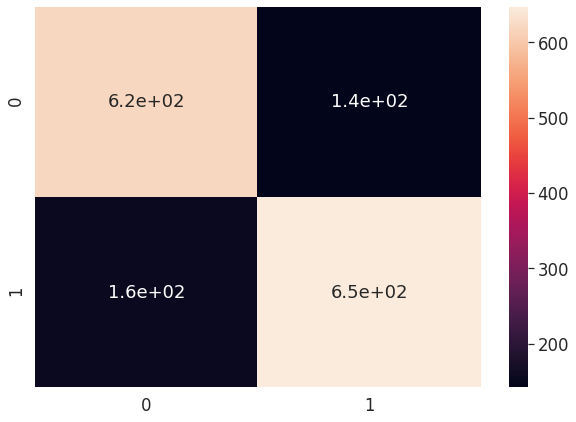

In [273]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(valid_tags, pred_tags)

df_cm = pd.DataFrame(conf_mat)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()


We can't look at accuracy with confidence. Indeed, our sample is really unbalanced and thus classifying all text as male would already give a 0.75 accuracy. This is exactly what happens here



In [274]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Valid F1_score
epoch,,,,
1,0.578801,0.490902,0.774872,0.783303
2,0.478315,0.566289,0.810587,0.813325


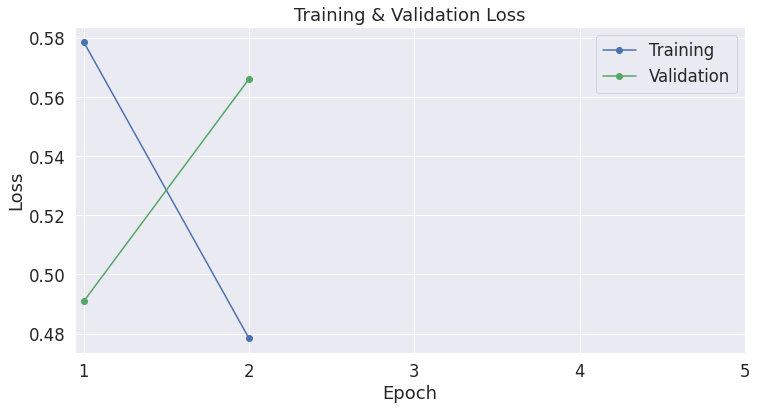

In [275]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

Our model is completely over fitting after 2 epochs !

## Evaluation 

In [276]:

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_dev.shape[0]))

# Create sentence and label lists
texts = df_dev.Texte.values
labels = df_dev.sexe.values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
# Apply function to our corpus
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                   )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
    input_ids.append(encoded_dict['input_ids'])
 
    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 8  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 160



In [277]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
gender_model1.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = gender_model1(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  #predictions.append(logits)
  #true_labels.append(label_ids)
  val_batch_preds = np.argmax(logits, axis=1)
  val_batch_labels = label_ids
  predictions.extend(val_batch_preds)
  true_labels.extend(val_batch_labels)


print('    DONE.')

Predicting labels for 160 test sentences...
    DONE.


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [0]:
pred_tags = [i for i in predictions]
true_tags = [i for i in true_labels]

In [280]:
f1_score(true_tags,pred_tags)

0.8251748251748251

In [281]:
accuracy_score(true_tags, pred_tags)

0.84375

In [0]:
df_true_pred=pd.DataFrame([true_tags,pred_tags]).transpose()

In [0]:
df_true_pred.columns=['true_tags','pred_tags']

In [284]:
df_true_pred[df_true_pred['true_tags']!=df_true_pred['pred_tags']]

,true_tags,pred_tags
26,0,1
31,0,1
39,0,1
46,1,0
50,1,0
55,1,0
59,1,0
63,0,1
65,1,0
75,0,1


RESTE A FAIRE A VOIR AVEC MELCHIOR 
A discuter : 
- Texte preprocessing ? ENlever monsieur, madame ? 
- quel autre modèle réaliser (type de texte qu'on prend...etc) 
- optimizer
- number of batch / sample / epochs (low) 
- change criterion 
- More analysis ? what to add ? 

A demander : 
- Comment je split le texte en plusieurs 


RESTE A FAIRE MORGANE : 
- improve loop ? 
- Analyse test set (which one were not well predicted)
- Enregistrer les modèles ? (A voir pour montrer les résultats un a un avec les différentes données de base A DISCUTER) 

TRUC QUE J'AIMERAIS FAIRE : 
Analyser une phrase avec le score. 

INTERVIEW TEST ???? Si base de données déjà prête ca run sur ce code sans soucis 



In [0]:
@article{Wolf2019HuggingFacesTS,
  title={HuggingFace's Transformers: State-of-the-art Natural Language Processing},
  author={Thomas Wolf and Lysandre Debut and Victor Sanh and Julien Chaumond and Clement Delangue and Anthony Moi and Pierric Cistac and Tim Rault and R'emi Louf and Morgan Funtowicz and Jamie Brew},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.03771}
}

SyntaxError: ignored